<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [2]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [3]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

<h3><font color = "#079e05"> Image </font></h3>

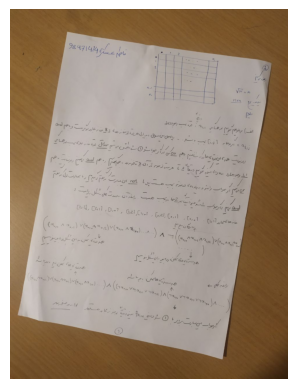

In [4]:
im = cv2.imread('images/Q4/myimg.jpg')
imshow(im)

<h3><font color = "#079e05"> Process </font></h3>

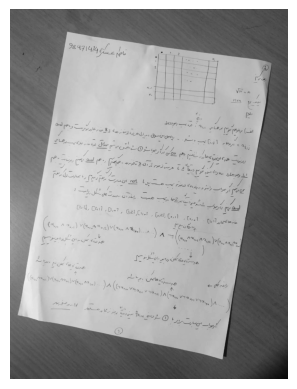

In [5]:
#Grayscale
img = im.copy()  
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(grayimg)

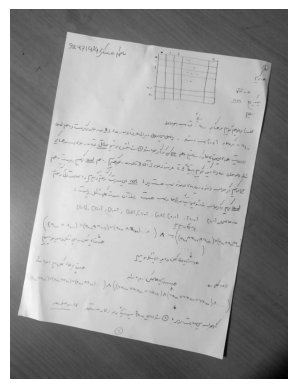

In [6]:
# Bilateral filter
bilateralimg = cv2.bilateralFilter(grayimg, 5, 10, 10)
imshow(bilateralimg)

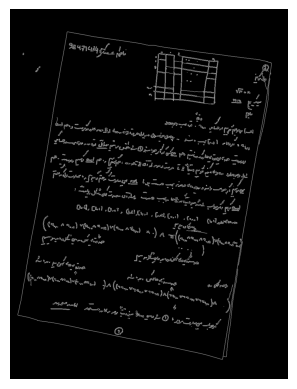

In [7]:
# canny
edgesimg = cv2.Canny(bilateralimg,10,150)
imshow(edgesimg)

[[ 199.   78.]
 [  26. 1057.]
 [ 732. 1212.]
 [ 902.  186.]]


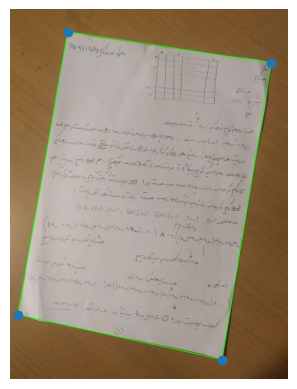

In [8]:
# Contour Detection
img1=im.copy()
# Find contours in the image
contours, hierarchy = cv2.findContours(edgesimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the paper's contour
for c in contours:
    # Find the contour perimeter
    perimeter = cv2.arcLength(c, True)

    # Approximate the paper's contour with approxPolyDP function
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    cornerpoints=[]
    # If the contour has four sides, show it
    if len(approx) == 4:
        cv2.drawContours(img1, [approx], -1, (0, 255, 0), 2)
        for point in approx:
            x, y = point.ravel()
            cornerpoints.append([x,y])
cornerpoints=np.array(cornerpoints, dtype = 'object')
cornerpoints=np.float32(cornerpoints)        
print(cornerpoints)        
imshow(img1)
plt.scatter([x for x, y in cornerpoints], [y for x, y in cornerpoints])       
        

[[ 199.   78.]
 [ 902.  186.]
 [ 732. 1212.]
 [  26. 1057.]]


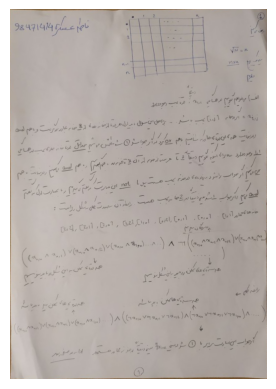

In [12]:
# Reorder the corner points
cornerpoints = reorder(cornerpoints)


print(cornerpoints)

# Assign the corner points to variables
(w1, w2, h1, h2) = cornerpoints

# Calculate the width and height of the image
FirstWidth = np.sqrt((((w2[1] - w1[1]) ** 2) + (w2[0] - w1[0]) ** 2))
SecondWidth = np.sqrt((((h1[1] - h2[1]) ** 2) + (h1[0] - h2[0]) ** 2))
FirstHeight = np.sqrt((((w2[1] - h1[1]) ** 2) + (w2[0] - h1[0]) ** 2))
SecondHeight = np.sqrt((((w1[1] - h2[1]) ** 2) + (w1[0] - h2[0]) ** 2))

# Determine the best width and height
BestWidth = max(int(FirstWidth), int(SecondWidth))
BestHeight = max(int(FirstHeight), int(SecondHeight))

# Define the destination points for the perspective transform
a = [0, 0]
b = [BestWidth - 1, 0]
c = [BestWidth - 1, BestHeight - 1]
d = [0, BestHeight - 1]
dest = np.array([ a, b, c, d], dtype = "float32")

# Get the perspective transform matrix
M = cv2.getPerspectiveTransform(cornerpoints, dest) 

# Apply the perspective transform to the image
finalimg = cv2.warpPerspective(im, M, (BestWidth, BestHeight))

# Display the cropped image
imshow(finalimg)

In [23]:
# Improve image quality

# Create a sharpening kernel
kernel_sharpening = np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]])

# Apply the sharpening kernel to the image
sharpeimg = cv2.filter2D(finalimg, -1, kernel_sharpening)

# Convert the image to the HSV color space
huesaturationvalue = cv2.cvtColor(sharpeimg, cv2.COLOR_BGR2HSV)

# Split the image into its hue, saturation, and value components
hue, saturation, value = cv2.split(huesaturationvalue)

# Set a limit for the value and saturation channels
lim = 255 - 40

# Increase the brightness of the pixels with a low value channel
value[value > lim] = 255
value[value <= lim] += 30

# Increase the saturation of the pixels with a low saturation channel
saturation[saturation > lim] = 255
saturation[saturation <= lim] += 35

# Combine the hue, saturation, and value channels back into an image
im3 = cv2.merge((hue, saturation, value))

# Convert the image back to the BGR color space
improveimg = cv2.cvtColor(im3, cv2.COLOR_HSV2BGR)


<h3><font color = "#079e05"> Show the result </font></h3>

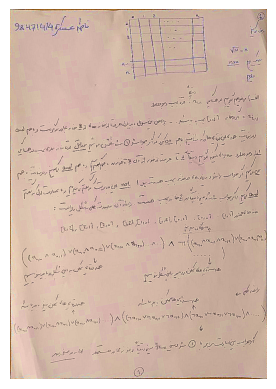

In [24]:
imshow(improveimg)